In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, precision_score, recall_score

In [2]:
notebook_name = '8_classes_EfficientNetV2S_96x96_bs_32'

In [3]:
train_dir = '../data/images/train'
val_dir = '../data/images/val'
test_dir = '../data/images/test'

train_df = pd.read_csv('../data/majority_train.csv')
val_df = pd.read_csv('../data/majority_val.csv')
test_df = pd.read_csv('../data/majority_test.csv')

In [4]:
train_df

,filename,class
0,fer0000001.png,neutral
1,fer0000002.png,neutral
2,fer0000004.png,neutral
3,fer0000005.png,neutral
4,fer0000006.png,sadness
...,...,...
25040,fer0028633.png,fear
25041,fer0028634.png,anger
25042,fer0028635.png,sadness
25043,fer0028636.png,neutral


In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.05,
    shear_range=np.rad2deg(np.arctan(0.05)),  # used to set the value by fraction instead of an angle
    horizontal_flip=True,
    fill_mode='reflect',
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

target_size = (96, 96)
interpolation = 'bilinear'
color_mode = 'grayscale'
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    target_size=target_size,
    interpolation=interpolation,
    color_mode=color_mode,
    batch_size=batch_size,
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=val_dir,
    target_size=target_size,
    interpolation=interpolation,
    color_mode=color_mode,
    batch_size=batch_size,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    target_size=target_size,
    interpolation=interpolation,
    color_mode=color_mode,
    batch_size=batch_size,
)

Found 25045 validated image filenames belonging to 8 classes.
Found 3191 validated image filenames belonging to 8 classes.
Found 3137 validated image filenames belonging to 8 classes.


In [6]:
labels = list(train_generator.class_indices.keys())

In [7]:
labels

['anger',
 'contempt',
 'disgust',
 'fear',
 'happiness',
 'neutral',
 'sadness',
 'surprise']

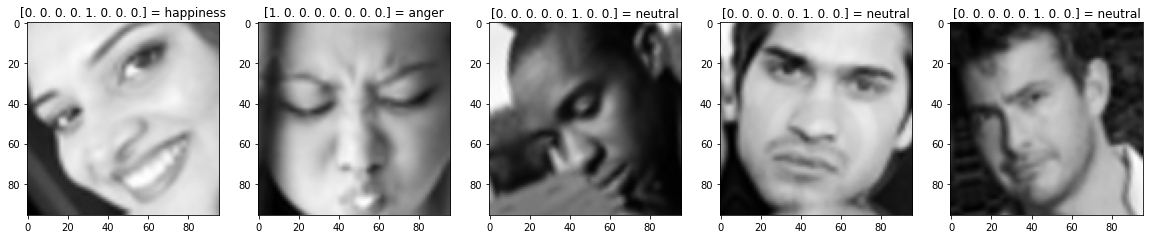

In [8]:
data = next(train_generator)

plt.figure(figsize=[20, 20])

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(f'{data[1][i]} = {labels[np.argmax(data[1][i])]}')
    plt.imshow(data[0][i], cmap='gray')

plt.show()

In [9]:
model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    input_shape=(96, 96, 1),
    weights=None,
    classes=8,
)

In [10]:
model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 96, 96, 1)    0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 24)   216         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 48, 48, 24)   96          ['stem_conv[0][0]']              
                                                                                   

                                                                  'block2b_add[0][0]']            
                                                                                                  
 block2d_expand_conv (Conv2D)   (None, 24, 24, 192)  82944       ['block2c_add[0][0]']            
                                                                                                  
 block2d_expand_bn (BatchNormal  (None, 24, 24, 192)  768        ['block2d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2d_expand_activation (Act  (None, 24, 24, 192)  0          ['block2d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2d_p

                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 12, 12, 256)  16384       ['block3d_add[0][0]']            
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 12, 12, 256)  1024       ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_expand_activation (Act  (None, 12, 12, 256)  0          ['block4a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4a_dwconv2 (DepthwiseConv  (None, 6, 6, 256)   2304        ['block4a_expand_activation[0][0]
 2D)      

 block4c_bn (BatchNormalization  (None, 6, 6, 512)   2048        ['block4c_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 6, 6, 512)   0           ['block4c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4c_se_squeeze (GlobalAver  (None, 512)         0           ['block4c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 512)    0           ['block4c_se_squeeze[0][0]']     
          

 block4e_se_reshape (Reshape)   (None, 1, 1, 512)    0           ['block4e_se_squeeze[0][0]']     
                                                                                                  
 block4e_se_reduce (Conv2D)     (None, 1, 1, 32)     16416       ['block4e_se_reshape[0][0]']     
                                                                                                  
 block4e_se_expand (Conv2D)     (None, 1, 1, 512)    16896       ['block4e_se_reduce[0][0]']      
                                                                                                  
 block4e_se_excite (Multiply)   (None, 6, 6, 512)    0           ['block4e_activation[0][0]',     
                                                                  'block4e_se_expand[0][0]']      
                                                                                                  
 block4e_project_conv (Conv2D)  (None, 6, 6, 128)    65536       ['block4e_se_excite[0][0]']      
          

 block5a_project_conv (Conv2D)  (None, 6, 6, 160)    122880      ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_project_bn (BatchNorma  (None, 6, 6, 160)   640         ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 6, 6, 960)    153600      ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 6, 6, 960)   3840        ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_e

                                                                                                  
 block5d_expand_activation (Act  (None, 6, 6, 960)   0           ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_dwconv2 (DepthwiseConv  (None, 6, 6, 960)   8640        ['block5d_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5d_bn (BatchNormalization  (None, 6, 6, 960)   3840        ['block5d_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5d_a

                                                                                                  
 block5f_activation (Activation  (None, 6, 6, 960)   0           ['block5f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5f_se_squeeze (GlobalAver  (None, 960)         0           ['block5f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5f_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5f_se_squeeze[0][0]']     
                                                                                                  
 block5f_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5f_se_reshape[0][0]']     
          

 block5h_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5h_se_reshape[0][0]']     
                                                                                                  
 block5h_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5h_se_reduce[0][0]']      
                                                                                                  
 block5h_se_excite (Multiply)   (None, 6, 6, 960)    0           ['block5h_activation[0][0]',     
                                                                  'block5h_se_expand[0][0]']      
                                                                                                  
 block5h_project_conv (Conv2D)  (None, 6, 6, 160)    153600      ['block5h_se_excite[0][0]']      
                                                                                                  
 block5h_project_bn (BatchNorma  (None, 6, 6, 160)   640         ['block5h_project_conv[0][0]']   
 lization)

 block6a_project_bn (BatchNorma  (None, 3, 3, 256)   1024        ['block6a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_expand_conv (Conv2D)   (None, 3, 3, 1536)   393216      ['block6a_project_bn[0][0]']     
                                                                                                  
 block6b_expand_bn (BatchNormal  (None, 3, 3, 1536)  6144        ['block6b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6b_expand_activation (Act  (None, 3, 3, 1536)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
          

 ivation)                                                                                         
                                                                                                  
 block6d_dwconv2 (DepthwiseConv  (None, 3, 3, 1536)  13824       ['block6d_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 3, 3, 1536)  6144        ['block6d_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 3, 3, 1536)  0           ['block6d_bn[0][0]']             
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 block6f_se_squeeze (GlobalAver  (None, 1536)        0           ['block6f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 1536)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 64)     98368       ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1536)   99840       ['block6f_se_reduce[0][0]']      
          

 block6h_se_expand (Conv2D)     (None, 1, 1, 1536)   99840       ['block6h_se_reduce[0][0]']      
                                                                                                  
 block6h_se_excite (Multiply)   (None, 3, 3, 1536)   0           ['block6h_activation[0][0]',     
                                                                  'block6h_se_expand[0][0]']      
                                                                                                  
 block6h_project_conv (Conv2D)  (None, 3, 3, 256)    393216      ['block6h_se_excite[0][0]']      
                                                                                                  
 block6h_project_bn (BatchNorma  (None, 3, 3, 256)   1024        ['block6h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6h_a

                                                                                                  
 block6j_add (Add)              (None, 3, 3, 256)    0           ['block6j_project_bn[0][0]',     
                                                                  'block6i_add[0][0]']            
                                                                                                  
 block6k_expand_conv (Conv2D)   (None, 3, 3, 1536)   393216      ['block6j_add[0][0]']            
                                                                                                  
 block6k_expand_bn (BatchNormal  (None, 3, 3, 1536)  6144        ['block6k_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6k_expand_activation (Act  (None, 3, 3, 1536)  0           ['block6k_expand_bn[0][0]']      
 ivation) 

 block6m_expand_activation (Act  (None, 3, 3, 1536)  0           ['block6m_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6m_dwconv2 (DepthwiseConv  (None, 3, 3, 1536)  13824       ['block6m_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6m_bn (BatchNormalization  (None, 3, 3, 1536)  6144        ['block6m_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6m_activation (Activation  (None, 3, 3, 1536)  0           ['block6m_bn[0][0]']             
 )        

 block6o_activation (Activation  (None, 3, 3, 1536)  0           ['block6o_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6o_se_squeeze (GlobalAver  (None, 1536)        0           ['block6o_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6o_se_reshape (Reshape)   (None, 1, 1, 1536)   0           ['block6o_se_squeeze[0][0]']     
                                                                                                  
 block6o_se_reduce (Conv2D)     (None, 1, 1, 64)     98368       ['block6o_se_reshape[0][0]']     
                                                                                                  
 block6o_s

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
  )

In [12]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.1,
    patience=10,
    verbose=2,
)

In [13]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=20,
    restore_best_weights=True,
    verbose=2,
)

In [14]:
min_loss_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/min_loss.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=2,
)

In [15]:
max_accuracy_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/max_accuracy.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=2,
)

In [16]:
max_precision_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/max_precision.h5',
    monitor='val_precision',
    mode='max',
    save_best_only=True,
    verbose=2,
)

In [17]:
max_recall_callback = tf.keras.callbacks.ModelCheckpoint(
    f'../models/{notebook_name}/max_recall.h5',
    monitor='val_recall',
    mode='max',
    save_best_only=True,
    verbose=2,
)

In [ ]:
fit_history = model.fit(
    train_generator,
    epochs=300,
    validation_data=val_generator,
    callbacks=[
        lr_callback,
        early_stop_callback,
        min_loss_callback,
        max_accuracy_callback,
        max_precision_callback,
        max_recall_callback,
    ],
    verbose=2,
)

Epoch 1/300

Epoch 1: val_loss improved from inf to 1.68592, saving model to ../models/EfficientNetV2S_96x96_32\min_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.38170, saving model to ../models/EfficientNetV2S_96x96_32\max_accuracy.h5

Epoch 1: val_precision improved from -inf to 0.44939, saving model to ../models/EfficientNetV2S_96x96_32\max_precision.h5

Epoch 1: val_recall improved from -inf to 0.23096, saving model to ../models/EfficientNetV2S_96x96_32\max_recall.h5
783/783 - 190s - loss: 1.9051 - accuracy: 0.3236 - precision: 0.3305 - recall: 0.0544 - val_loss: 1.6859 - val_accuracy: 0.3817 - val_precision: 0.4494 - val_recall: 0.2310 - lr: 0.0100 - 190s/epoch - 242ms/step
Epoch 2/300

Epoch 2: val_loss improved from 1.68592 to 1.46460, saving model to ../models/EfficientNetV2S_96x96_32\min_loss.h5

Epoch 2: val_accuracy improved from 0.38170 to 0.47352, saving model to ../models/EfficientNetV2S_96x96_32\max_accuracy.h5

Epoch 2: val_precision improved from 0.44939 to 0.

Epoch 14/300

Epoch 14: val_loss did not improve from 0.66079

Epoch 14: val_accuracy did not improve from 0.76966

Epoch 14: val_precision did not improve from 0.81825

Epoch 14: val_recall did not improve from 0.72798
783/783 - 166s - loss: 0.6994 - accuracy: 0.7532 - precision: 0.8057 - recall: 0.7015 - val_loss: 0.6846 - val_accuracy: 0.7603 - val_precision: 0.8026 - val_recall: 0.7111 - lr: 0.0100 - 166s/epoch - 211ms/step
Epoch 15/300

Epoch 15: val_loss did not improve from 0.66079

Epoch 15: val_accuracy did not improve from 0.76966

Epoch 15: val_precision did not improve from 0.81825

Epoch 15: val_recall did not improve from 0.72798
783/783 - 166s - loss: 0.6735 - accuracy: 0.7635 - precision: 0.8104 - recall: 0.7137 - val_loss: 0.6663 - val_accuracy: 0.7647 - val_precision: 0.8007 - val_recall: 0.7277 - lr: 0.0100 - 166s/epoch - 211ms/step
Epoch 16/300

Epoch 16: val_loss did not improve from 0.66079

Epoch 16: val_accuracy did not improve from 0.76966

Epoch 16: val_precis


Epoch 29: val_recall did not improve from 0.78909
783/783 - 168s - loss: 0.5286 - accuracy: 0.8164 - precision: 0.8451 - recall: 0.7851 - val_loss: 0.5213 - val_accuracy: 0.8201 - val_precision: 0.8599 - val_recall: 0.7809 - lr: 0.0100 - 168s/epoch - 215ms/step
Epoch 30/300

Epoch 30: val_loss did not improve from 0.52131

Epoch 30: val_accuracy did not improve from 0.82012

Epoch 30: val_precision did not improve from 0.85990

Epoch 30: val_recall did not improve from 0.78909
783/783 - 165s - loss: 0.5161 - accuracy: 0.8165 - precision: 0.8479 - recall: 0.7866 - val_loss: 0.6857 - val_accuracy: 0.7628 - val_precision: 0.7905 - val_recall: 0.7330 - lr: 0.0100 - 165s/epoch - 211ms/step
Epoch 31/300

Epoch 31: val_loss did not improve from 0.52131

Epoch 31: val_accuracy did not improve from 0.82012

Epoch 31: val_precision did not improve from 0.85990

Epoch 31: val_recall did not improve from 0.78909
783/783 - 165s - loss: 0.5082 - accuracy: 0.8179 - precision: 0.8454 - recall: 0.7892

Epoch 47/300

Epoch 47: val_loss did not improve from 0.45555

Epoch 47: val_accuracy did not improve from 0.83924

Epoch 47: val_precision did not improve from 0.85990

Epoch 47: val_recall did not improve from 0.82827
783/783 - 165s - loss: 0.4264 - accuracy: 0.8500 - precision: 0.8717 - recall: 0.8291 - val_loss: 0.4757 - val_accuracy: 0.8367 - val_precision: 0.8557 - val_recall: 0.8229 - lr: 0.0100 - 165s/epoch - 211ms/step
Epoch 48/300

Epoch 48: val_loss did not improve from 0.45555

Epoch 48: val_accuracy did not improve from 0.83924

Epoch 48: val_precision did not improve from 0.85990

Epoch 48: val_recall did not improve from 0.82827
783/783 - 165s - loss: 0.4209 - accuracy: 0.8500 - precision: 0.8704 - recall: 0.8296 - val_loss: 0.5059 - val_accuracy: 0.8308 - val_precision: 0.8510 - val_recall: 0.8126 - lr: 0.0100 - 165s/epoch - 211ms/step
Epoch 49/300

Epoch 49: val_loss did not improve from 0.45555

Epoch 49: val_accuracy did not improve from 0.83924

Epoch 49: val_precis


Epoch 63: val_accuracy did not improve from 0.86587

Epoch 63: val_precision did not improve from 0.87981

Epoch 63: val_recall did not improve from 0.85334
783/783 - 165s - loss: 0.2754 - accuracy: 0.8997 - precision: 0.9111 - recall: 0.8901 - val_loss: 0.4233 - val_accuracy: 0.8571 - val_precision: 0.8717 - val_recall: 0.8477 - lr: 1.0000e-03 - 165s/epoch - 211ms/step
Epoch 64/300

Epoch 64: val_loss did not improve from 0.40681

Epoch 64: val_accuracy did not improve from 0.86587

Epoch 64: val_precision did not improve from 0.87981

Epoch 64: val_recall did not improve from 0.85334
783/783 - 171s - loss: 0.2721 - accuracy: 0.9019 - precision: 0.9129 - recall: 0.8918 - val_loss: 0.4172 - val_accuracy: 0.8565 - val_precision: 0.8699 - val_recall: 0.8464 - lr: 1.0000e-03 - 171s/epoch - 218ms/step
Epoch 65/300

Epoch 65: val_loss did not improve from 0.40681

Epoch 65: val_accuracy did not improve from 0.86587

Epoch 65: val_precision did not improve from 0.87981

Epoch 65: val_recall

In [8]:
def draw_graphics(fit_history, metric_name):
    history = fit_history.history
    
    metric = history[metric_name]
    val_metric = history[f'val_{metric_name}']
    
    epochs = range(1, len(metric) + 1)

    plt.plot(epochs, metric, 'b', label=f'Training {metric_name}')
    plt.plot(epochs, val_metric, 'r', label=f'Validation {metric_name}')
    
    plt.title(f'Training and validation {metric_name}')
    plt.xlabel('epochs')
    plt.ylabel(f'{metric_name}')
    plt.legend()
    plt.show()

In [ ]:
draw_graphics(fit_history, 'loss')

In [ ]:
draw_graphics(fit_history, 'accuracy')

In [ ]:
draw_graphics(fit_history, 'precision')

In [ ]:
draw_graphics(fit_history, 'recall')

In [9]:
x_test = []
y_test = []

for image_name, emotion in test_df.values:
    image = tf.keras.preprocessing.image.load_img(
        os.path.join(test_dir, image_name),
        target_size=target_size,
        interpolation=interpolation,
        color_mode=color_mode,
    )
    
    x_test.append(tf.keras.preprocessing.image.img_to_array(image))
    y_test.append(labels.index(emotion))
        
x_test = np.array(x_test)
y_test = np.array(y_test)

In [10]:
def draw_confusion_matrix(y_true, y_pred, labels):
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    display = ConfusionMatrixDisplay(cm, display_labels=labels)

    _, ax = plt.subplots(figsize=(10, 10))
    display.plot(cmap=plt.cm.Blues, ax=ax)
    plt.show()

In [11]:
def compute_metrics(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 score: {2 * (precision * recall) / (precision + recall) * 100:.2f}%')

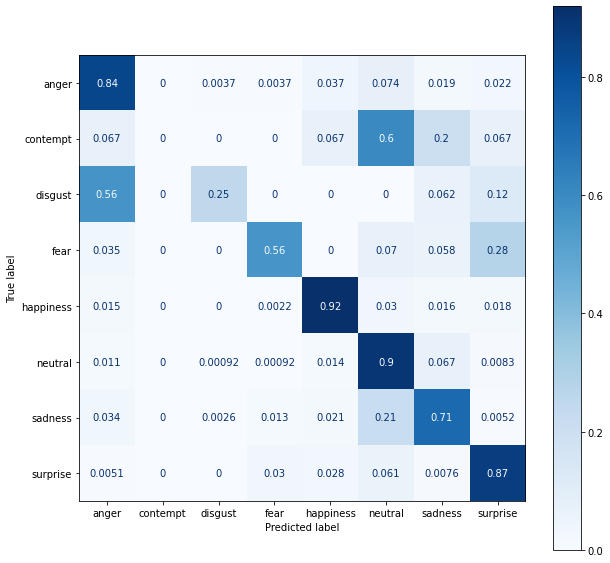

Accuracy: 85.56%
Precision: 68.16%
Recall: 63.06%
F1 score: 65.51%


In [12]:
min_loss_model = tf.keras.models.load_model(f'../models/{notebook_name}/min_loss.h5')
y_pred = min_loss_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)

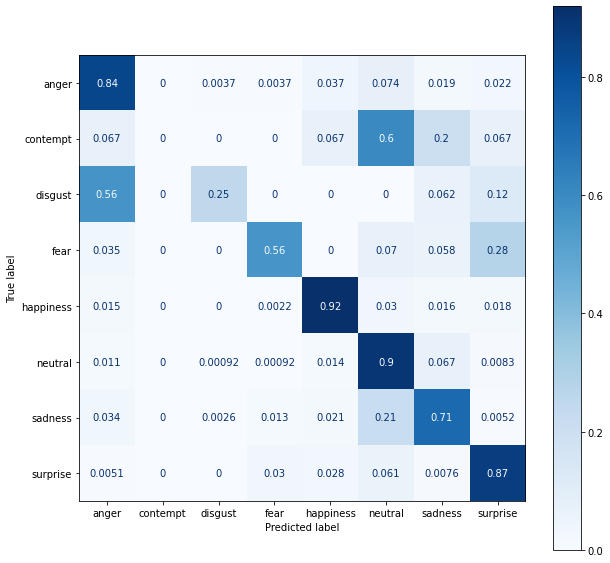

Accuracy: 85.56%
Precision: 68.16%
Recall: 63.06%
F1 score: 65.51%


In [13]:
max_accuracy_model = tf.keras.models.load_model(f'../models/{notebook_name}/max_accuracy.h5')
y_pred = max_accuracy_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)

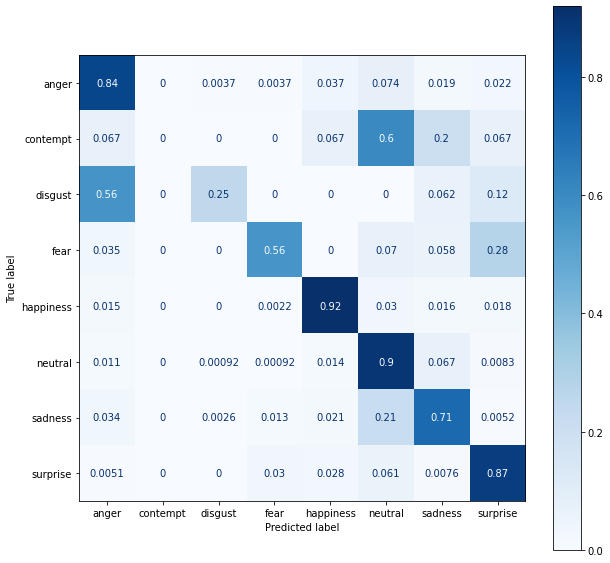

Accuracy: 85.56%
Precision: 68.16%
Recall: 63.06%
F1 score: 65.51%


In [14]:
max_precision_model = tf.keras.models.load_model(f'../models/{notebook_name}/max_precision.h5')
y_pred = max_precision_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)

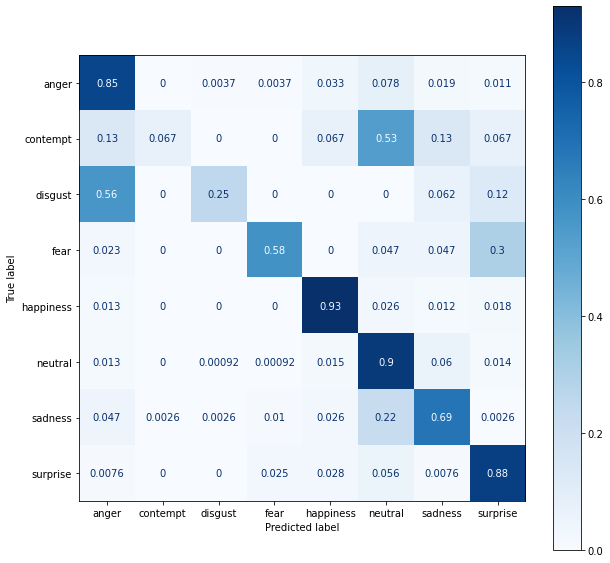

Accuracy: 85.81%
Precision: 75.12%
Recall: 64.22%
F1 score: 69.25%


In [15]:
# best
max_recall_model = tf.keras.models.load_model(f'../models/{notebook_name}/max_recall.h5')
y_pred = max_recall_model.predict(x_test)

draw_confusion_matrix(y_test, y_pred, labels)
compute_metrics(y_test, y_pred)